<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/SolarData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solar Data Classification

In this notebook, we perform various visualization and classification techniques on a dataset collected at ASU containing labeled data about the SenSIP solar array.  

![picture](https://sensip.engineering.asu.edu/wp-content/uploads/2012/06/Solar_cells.jpg)

This data contains the following classes:
* *Degraded* solar panels
* *Shaded* solar panels
* *Soiled*, or dirty, solar panels
* Solar panels that have a *Short Circuit*
* And good clean solar panels that we call '*STC*' for Standard Test Conditions. 

The features this data has are:
* *DCArrayOutput_W_* which outputs the Watts of energy produced
* *Vmp* which is the maximum voltage when connected to a load
* *Imp* which is the maximum current when connected to a load
* *CellTemperature_C_* which is the temperature in celsius
* *PlaneOfArrayIrradiance_W_m_2_* provides the watts per meter squared
* *Fill Factor* which is the ratio of the maximum obtainable power to the product of the open circuit voltage and short circuit current
* *Gamma* 
* *Pmp*
* *Voc* is the open circuit voltage
* *Isc* is the short circuit current

Using this data, we perform a **dimensionality reduction** using PCA to better visualize the data.  We then classify the data using **Logistic Regression**, **Support Vector Machines (SVMs)**, and simple **Neural Networks** (Multi-layer Perceptron classifier).  Finally, we perform unsupervised clustering using **K-Means** for comparison.

## Load Solar Data

In this section, we will load the solar data into Colab and put it into two arrays - one, named X, will contain all of the known data with 10 features, and the other, y, will contain the class numbers for each datapoint in X

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()  #Upload asu_solar_dataset.csv here

## Clean the Data
Verify that it loaded correctly and separate the data from the labels and convert it to a numpy array from a pandas dataframe.

In [3]:
data_path = '/content/asu_solar_dataset.csv'
df = pd.read_csv(data_path, delimiter=',')  #here we're reading our csv file into a Pandas DataFrame

In [4]:
# This is what our dataframe looks like to begin with
df.loc[0:2, :]  # We're only looking at the first three rows

,DCArrayOutput_W_,Vmp,Imp,CellTemperature_C_,PlaneOfArrayIrradiance_W_m_2_,Fill Factor,Gamma,Pmp,Voc,Isc,Degraded,Shaded,Soiled,SC,STC
0,4715.409,36.331723,1.369981,16.107,281.111,4.669695,0.177061,49.773762,44.338856,5.242090,0,0,0,0,1
1,9076.926,37.436438,2.559325,26.713,527.216,2.391698,0.181732,95.811997,44.023777,5.205219,0,0,0,0,1
2,11978.364,35.924148,3.519590,36.542,712.905,1.913899,0.177356,126.438287,45.239121,5.349134,0,0,0,0,1


In [5]:
# We're going to start by separating the data from the labels.  Here, 
# we delete the labels to isolate the data into a new dataframe

df_X = df.drop(columns=['Degraded', 'Shaded', 'Soiled', 'SC', 'STC'])
df_X #.loc[0:2,:] #Look at the dataframe to verify the 

,DCArrayOutput_W_,Vmp,Imp,CellTemperature_C_,PlaneOfArrayIrradiance_W_m_2_,Fill Factor,Gamma,Pmp,Voc,Isc
0,4715.409,36.331723,1.369981,16.107,281.11100,4.669695,0.177061,49.773762,44.338856,5.242090
1,9076.926,37.436438,2.559325,26.713,527.21600,2.391698,0.181732,95.811997,44.023777,5.205219
2,11978.364,35.924148,3.519590,36.542,712.90500,1.913899,0.177356,126.438287,45.239121,5.349134
3,13606.691,35.296861,4.069092,40.619,820.48600,1.637532,0.175050,143.626183,44.804407,5.249316
4,13953.936,34.555717,4.262436,45.436,861.07700,1.629109,0.171055,147.291547,44.492927,5.393082
...,...,...,...,...,...,...,...,...,...,...
21480,9918.107,32.878335,3.184198,56.338,648.85575,2.231807,0.161347,104.691129,44.903990,5.203332
21481,9498.023,32.857103,3.051301,56.476,622.77825,2.355273,0.160983,100.256909,44.016109,5.364680
21482,8470.261,34.315388,2.605487,46.998,531.26175,2.607679,0.168294,89.408311,44.419803,5.248744
21483,6168.314,34.718963,1.875344,44.375,389.89800,3.547519,0.166992,65.109981,44.582852,5.180891


In [6]:
#Now we convert the data into a numpy array - many of the algorithms we're 
#interested in will only take numpy arrays, not dataframes
X = df_X.to_numpy()
X[:3,:] #check to make sure it converted it properly

array([[4.71540900e+03, 3.63317230e+01, 1.36998076e+00, 1.61070000e+01,
        2.81111000e+02, 4.66969485e+00, 1.77060882e-01, 4.97737617e+01,
        4.43388563e+01, 5.24209008e+00],
       [9.07692600e+03, 3.74364378e+01, 2.55932461e+00, 2.67130000e+01,
        5.27216000e+02, 2.39169826e+00, 1.81731959e-01, 9.58119967e+01,
        4.40237770e+01, 5.20521867e+00],
       [1.19783640e+04, 3.59241479e+01, 3.51959042e+00, 3.65420000e+01,
        7.12905000e+02, 1.91389893e+00, 1.77356431e-01, 1.26438287e+02,
        4.52391213e+01, 5.34913355e+00]])

## Create Categorical Labels

Original data was labeled using binary columns for a one-hot encoding. Here, we convert the one-hot labels into categorical labels (a single column vector where each category has a different integer value).

$$ $$ 

Ex: 
One-hot encoding labels may look like:
$$ y_{one-hot}  = 
\begin{bmatrix}
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
1 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

$$ $$ 

While the equivalent categorical label will look like:

(Remember, in python we start counting at 0, not at 1)
$$
y = \begin{bmatrix}
1\\
2\\
0
\end{bmatrix}
$$




In [7]:
# Here, we drop the data to obtain the labels.  We put them in their own dataframe.

df_y = df.drop(columns=['DCArrayOutput_W_', 'Vmp', 'Imp', 'CellTemperature_C_', 
                        'PlaneOfArrayIrradiance_W_m_2_', 'Fill Factor', 'Gamma',
                        'Pmp', 'Voc', 'Isc'])
df_y #.loc[:3,:] #Labels in a one-hot encoding

,Degraded,Shaded,Soiled,SC,STC
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
21480,0,1,0,0,0
21481,0,1,0,0,0
21482,0,1,0,0,0
21483,0,1,0,0,0


In [8]:
# Data labels are originally stored in a one-hot encoding, meaning that each 
# column represents a fault type and contains either a zero or a 1
y_onehot = df_y.to_numpy()
y_onehot[:3,:]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [9]:
# We will covert the one-hot encoding into integer class numbers.
y = np.argmax(y_onehot, axis=1)

# Here, 0 = degraded
#       1 = shaded
#       2 = soiled
#       3 = short circuit
#       4 = standard test conditions (no faults)

print(y)
print(y.shape)

[4 4 4 ... 1 1 1]
(21485,)


# Visualize the Data (Using Dimensionality Reduction)

In order to visualize the 10 dimensional data effectively, we're going to perform a dimensionality reduction algorithm called PCA (Principal Component Analysis).  This uses Singular Value Decomposition to identify the eigenvectors in the data, and removes all but the most important.

## Three Dimensions

In [10]:
from sklearn.decomposition import PCA

# Transform the data into a dimensionality reduced dataset in 3 dimensions
pca_model3 = PCA(n_components=3)
X_red3 = pca_model3.fit_transform(X)  #X_red is short for X_reduced3

In [11]:
#We can verify that our new matrix exists in only three dimensions (three columns)
X_red3[1:5,:]

array([[ 1.80730409e+03, -1.28337250e+02, -5.74421433e+00],
       [ 4.71475626e+03, -1.50077960e+02,  4.17291284e+00],
       [ 6.34669489e+03, -1.58988487e+02,  9.79757335e+00],
       [ 6.69597915e+03, -1.43074901e+02,  1.13768378e+01]])

Now we can plot our reduced data.  You can play with the opacity slider to be able to "see through" the data to see where it overlaps.

In [12]:
Opacity = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}

#Here, we can create a list of the colors we'd like 
#to use in our graphs below.
colors = ['purple', 'red', 'blue', 'green', 'yellow']

In [55]:
import plotly.graph_objects as go

fig1 = go.Figure()

fig1.add_trace(go.Scatter3d(x=X_red3[y==0,0], y=X_red3[y==0,1], z=X_red3[y==0,2], 
                           mode='markers',
                           marker=dict(size=5, color=colors[0], opacity=Opacity),
                           name="Degraded"))
fig1.add_trace(go.Scatter3d(x=X_red3[y==1,0], y=X_red3[y==1,1], z=X_red3[y==1,2], 
                           mode='markers',
                           marker=dict(size=5, color=colors[1], opacity=Opacity),
                           name="Shaded"))
fig1.add_trace(go.Scatter3d(x=X_red3[y==2,0], y=X_red3[y==2,1], z=X_red3[y==2,2], 
                           mode='markers',
                           marker=dict(size=5, color=colors[2], opacity=Opacity),
                           name="Soiled"))
fig1.add_trace(go.Scatter3d(x=X_red3[y==3,0], y=X_red3[y==3,1], z=X_red3[y==3,2], 
                           mode='markers',
                           marker=dict(size=5, color=colors[3], opacity=Opacity),
                           name="Short Circuit"))
fig1.add_trace(go.Scatter3d(x=X_red3[y==4,0], y=X_red3[y==4,1], z=X_red3[y==4,2], 
                           mode='markers',
                           marker=dict(size=5, color=colors[4], opacity=Opacity),
                           name="No Faults"))
fig1.show()

Hmmm.... It looks like the third dimension doesn't really add that much.  Let's see what happens if we plot it in only two dimensions

## Two Dimensions

In [14]:
# Transform the data into a dimensionality reduced dataset in 2 dimensions
pca_model2 = PCA(n_components=2)
X_red2 = pca_model2.fit_transform(X)  #X_red2 is short for X_reduced2

In [15]:
Opacity = 1 #@param {type:"slider", min:0, max:1, step:0.1}

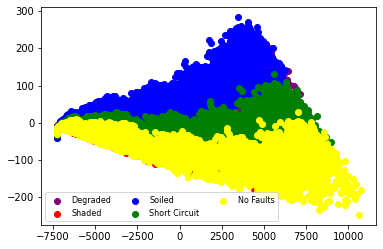

In [16]:
degraded = plt.scatter(X_red2[y==0, 0], X_red2[y==0, 1], color=colors[0], alpha=Opacity)
shaded = plt.scatter(X_red2[y==1, 0], X_red2[y==1, 1], color=colors[1], alpha=Opacity)
soiled = plt.scatter(X_red2[y==2, 0], X_red2[y==2, 1], color=colors[2], alpha=Opacity)
sc = plt.scatter(X_red2[y==3, 0], X_red2[y==3, 1], color=colors[3], alpha=Opacity)
stc = plt.scatter(X_red2[y==4, 0], X_red2[y==4, 1], color=colors[4], alpha=Opacity)

plt.legend((degraded, shaded, soiled, sc, stc),
           ('Degraded', 'Shaded', 'Soiled', 'Short Circuit', 'No Faults'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

#Logistic Regression
Logistic regression is a binary classification algorithm that produces probabilistic outputs over two classes - often called the positive and negative classes.  Typically, if the class sizes are skewed, the smaller class is called positive and the larger one is negative.  When classifying data using logistic regression, the classifier will calculate the probability that each datapoint belongs to the positive class.

Logistic regression works by fitting data to a sigmoid function.  The logit sigmoid function has the following equation:

$$Sigmoid(x)=\frac{1}{1+e^{-\theta x}}$$


## Binary Classification

First, we're going to isolate the two classes we'd like to classify. In binary classification, the two sets are often called the **positive** and **negative** classes.  In general, if one set is smaller than the other, the smaller set is called the **positive** class.


### Select Classes for Binary Classification


In [17]:
Positive_class = 'Soiled' #@param ["Degraded", "Shaded", "Soiled", "Short Circuit"]
Negative_class = 'No Faults' #@param ["No Faults", "Degraded", "Shaded", "Soiled", "Short Circuit", "All Others"]

#@markdown Note: the Positive and Negative classes **MUST** be different from one another. 

if Positive_class == 'Degraded':
    pos_class = 0
elif Positive_class == 'Shaded':
    pos_class = 1
elif Positive_class == 'Soiled':
    pos_class = 2
elif Positive_class == 'Short Circuit':
    pos_class = 3

X_pos = X[y == pos_class, :]

if Negative_class == 'Degraded':
    X_neg = X[y == 0, :]
elif Negative_class == 'Shaded':
    X_neg = X[y == 1, :]
elif Negative_class == 'Soiled':
    X_neg = X[y == 2, :]
elif Negative_class == 'Short Circuit':
    X_neg = X[y == 3, :]
elif Negative_class == 'No Faults':
    X_neg = X[y == 4, :]
elif Negative_class == 'All Others':
    X_neg = X[y != pos_class, :]

y_pos = np.ones((X_pos.shape[0], ))
y_neg = np.zeros((X_neg.shape[0], ))

X_binary = np.concatenate((X_pos, X_neg), axis=0)
y_binary = np.concatenate((y_pos, y_neg), axis=0)

### Break into train/validation/test sets
Before we can classify the data, we want to break the data into training, validation, and test sets.  

Our process will be as follows:
1. Train the data on the training set.
2. Test the data on the validation set.
3. Adjust any available hyperparameters.
4. Repeat steps 1-3 until you select the best hyperparameters for the data.
5. Train the data on the combinee training and validation sets using the selected hyperparameters from step 4.
6. Perform the final test on the reserved test set.

Notice that since the built in sklearn function "train_test_split" only breaks the sets into two parts, we have to use the function twice to get three sets.
* Once to separate the initial training data.
* Again to separate the validation and test sets from the remaining data.

In [18]:
from sklearn.model_selection import train_test_split

#Here, our training set is composed of 70% of the data and our validation
#and test sets are each composed of 15% of the data
x_train_binary, x_remaining, y_train_binary, y_remaining = train_test_split(X_binary, y_binary, test_size=0.3)
x_test_binary, x_val_binary, y_test_binary, y_val_binary = train_test_split(x_remaining, y_remaining, test_size=0.5)

print("Training Size   = ", x_train_binary.shape[0])
print("Validation Size = ", x_val_binary.shape[0])
print("Test Size       = ",  x_test_binary.shape[0])

Training Size   =  6015
Validation Size =  1290
Test Size       =  1289


### Tune hyperparameters
Train and test on the validation set while we try out different hyperparameter combination.  Hyperparameters in this example include the solver type and the number of itterations allowed.

In [19]:
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.metrics import accuracy_score

#Train and test on validation set
LR_model = LogisticRegression(random_state=0, solver='liblinear', max_iter=1000)

lr_binary_model = LR_model.fit(x_train_binary, y_train_binary)
y_hat_binary = lr_binary_model.predict(x_val_binary)

accuracy_binary_LR = accuracy_score(y_val_binary, y_hat_binary)
print('Validation accuracy = ', round(accuracy_binary_LR * 100, 2), "% accuracy.")

Validation accuracy =  96.59 % accuracy.


### Perform final tests
Once we have identified the ideal combination of hyperparameters, we want to retrain the data on the original training and validation data, so we can do a final test on the reserved test data.

Here, the final accuracy will likely be very similar to the validation accuracy.  This is because:
* Our hyperparameters are not data specific and thus will be unlikely to cause significant overfitting.
* We have sufficient data for effective learning.  That is, the 15% of the data originally randomly selected for testing is sufficient to provide a good mix of all of the classes.

In [20]:
x_final_train_binary = np.concatenate((x_train_binary, x_val_binary), axis=0)
y_final_train_binary = np.concatenate((y_train_binary, y_val_binary), axis=0)

lr_final_binary_model = LR_model.fit(x_final_train_binary, y_final_train_binary)

y_hat_binary_final_test = lr_final_binary_model.predict(x_test_binary)

accuracy = accuracy_score(y_test_binary, y_hat_binary_final_test)
print('Final test accuracy = ', round(accuracy * 100, 2), "% accuracy.")

Final test accuracy =  96.66 % accuracy.


### Confusion Matrix
We can plot the confusion matrix for this classification.

A confusion matrix provides the information on the correct predictions: true positives (TP) and true negatives (TN)

Along with how many samples the algorithm messed up: false positives (FP) and false negatives (FN).

![picture](https://miro.medium.com/max/712/1*Z54JgbS4DUwWSknhDCvNTQ.png)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



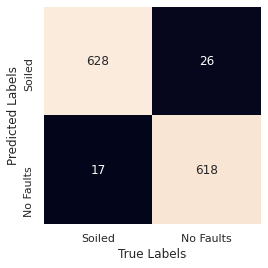

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

CM = confusion_matrix(y_test_binary, y_hat_binary_final_test)
ax = sns.heatmap(CM.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[Positive_class, Negative_class],
            yticklabels=[Positive_class, Negative_class])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');
plt.show()

### Summary Statistics
Next, let's print out some summary statistics.  

Some common summary statistics are:

* Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$ 


When the class sizes are imballanced, the F-score (or F1-score) is a better metric than accuracy.  It is equal to the harmonic mean between precision and recall.  Like accuracy, it ranges between 0 and 1.


* Precision = $\frac{TP}{TP + FP}$


* Recall = $\frac{TP}{TP + FP}$


* F-Score = $2*\frac{Precision \times Recall}{Precision + Recall}$




In [22]:
from sklearn.metrics import f1_score

TN, FP, FN, TP = CM.ravel()

precision_binary_lr = TP/(TP+FP)  #sklearn also has functions to calculate these
recall_binary_lr = TP/(TP+FN)     #or you can calculate them manually
accuracy_binary_lr = accuracy_score(y_test_binary, y_hat_binary_final_test) #these are calculated automatically
f1_score_binary_lr = f1_score(y_test_binary, y_hat_binary_final_test)       #using sklearn.

print('Test accuracy = ', round(accuracy_binary_lr * 100, 2))
print('F-score = ', round(f1_score_binary_lr * 100, 2))
print('Precision = ', round(precision_binary_lr * 100, 2))
print('Recall = ', round(recall_binary_lr * 100, 2))

Test accuracy =  96.66
F-score =  96.64
Precision =  97.32
Recall =  95.96


## Multi-class classification 

While traditionally, logistic regression is designed to work in scenarios with only two classes, it can be extended using a technique called "One-vs-all".  In this situation, if we have 5 classes for example, we would perform five binary classifications - one for each class against all the rest.  The final classification for each datapoint, is then calculated by voting between these five sub-classifiers.

Other techniques can also be used.  Using sklearn's LogisticRegression class, the choice of solver specifies which method is used to perform the multi-class classification.


### Break into train/validation/test sets

These are broken into training, validation, and test sets as before, only now all of the classes are used, not just two of them.

NOTE: All following algorithms will use this data breakdown and perform multi-class classification.

In [24]:
x_train_mc, x_remaining, y_train_mc, y_remaining = train_test_split(X, y, test_size=0.3)
x_test_mc, x_val_mc, y_test_mc, y_val_mc = train_test_split(x_remaining, y_remaining, test_size=0.5)

print("train_size = ", x_train_mc.shape[0])
print("val_size = ", x_val_mc.shape[0])
print("test_size = ",  x_test_mc.shape[0])

train_size =  15039
val_size =  3223
test_size =  3223


### Tune hyperparameters

Again, there aren't many hyperparameters available with logistic regression.  The only two in the following implementation are the solver and the maximum number of iterations.

If it doesn't converge, that means it hasn't found the optimal solution, but that doesn't mean you can't use the model.  

In [25]:
#Train and test on validation set
LR_model_mc = LogisticRegression(random_state=0, solver='lbfgs', max_iter=5000)

lr_model_mc = LR_model_mc.fit(x_train_mc, y_train_mc)
y_hat_mc = lr_model_mc.predict(x_val_mc)

accuracy_mc = accuracy_score(y_val_mc, y_hat_mc)
print('Validation accuracy = ', round(accuracy_mc * 100, 2), "%.")

Validation accuracy =  78.96 %.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Perform final tests

Whether or not the previous model converged, we can still perform our final tests on the testing data.

In [41]:
x_final_train_mc = np.concatenate((x_train_mc, x_val_mc), axis=0)
y_final_train_mc = np.concatenate((y_train_mc, y_val_mc), axis=0)

lr_final_model_mc = LR_model.fit(x_final_train_mc, y_final_train_mc)

y_hat_final_test_lr_mc = lr_final_model_mc.predict(x_test_mc)

final_accuracy_mc = accuracy_score(y_test_mc, y_hat_final_test_lr_mc)
print('Test accuracy = ', round(final_accuracy_mc * 100, 2), "%.")

Test accuracy =  75.92 %.


### Confusion Matrix

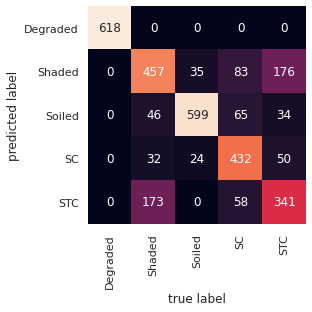

In [28]:
CM_mc = confusion_matrix(y_test_mc, y_hat_final_test_lr_mc)
ax = sns.heatmap(CM_mc.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

# Support Vector Machines (SVMs)

A Support Vector Machine, or SVM, is a popular traditional classification algorithm.  In this algorithm, the margin around the hyperplane separating the classes is maximized.  Kernels are commonly added to add additional calculated features to increase the data dimensionality.  SVMs are most effective when the data is well separated and can be ineffective and very slow when the data is not.

Notice that the function used to perform SVM classification is called SVC in sklearn.  That is because you can use SVMs to perform both classification (most common) and regression (uncommon) so sklearn provides both **SVC** and **SVR** functions respectively.

**NOTE: In this and the following algorithms, the multi-class train/validation/test sets defined above will be used.**



### Tune hyperparameters

As with logistic regression, there are not a lot of hyperparameters that need tuning with SVMs.  The exception are details about the kernels that are used.  Play with the values in the SVC function.

* The kernel options you want to try are ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’. 

* The degree is the degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

* The max_iter specifies the maximum number of itterations.  This is especially important for a linear kernel or it might continue indefinitely.  Notice that your results can decrease if the max_iter gets too high.

* The break_ties option being set to True will provide better results at the expense of computational time.

You will want to keep track of your accuracy scores for each set of hyperparameters that you try.  When I tried, I got the following.  I did not include the maximum iteration when the function converged before the limit I had set.

| Kernel Type | Polynomial Degree | Maximum Iterations | Accuracy |
|-------------|-------------------|--------------------|----------|
| poly        | 3                 |                    | 47.22%   |
| poly        | 5                 |                    | 47.72%   |
| linear      |                   | 3000               | 32.33%   |
| linear      |                   | 5000               | 55.94%   |
| linear      |                   | 7000               | 55.54%   |
| linear      |                   | 10000              | 40.83%   |
| rbf         |                   |                    | 41.48%   |
| sigmoid     |                   |                    | 18.46%   |

From this, we can see that using a linear kernel with a maximum iteration of around 5000 will provide the best results, though none of them are good and in fact the best option here provides a much worse result than the Logistic Regression classifier we created above.

In [40]:
from sklearn.svm import SVC

SVM_model = SVC(kernel='linear', degree=3, max_iter=5000, break_ties=True) 

svm_model = SVM_model.fit(x_train_mc, y_train_mc)
svm_y_hat = svm_model.predict(x_val_mc)

svm_accuracy = accuracy_score(y_val_mc, svm_y_hat)
print('Validation accuracy = ', round(svm_accuracy * 100, 2), "%.")

Validation accuracy =  55.94 %.


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



### Perform final tests
We still need to perform our final classification, despite the fact that this SVM really doesn't compare to logistic regression in terms of performance.

In [44]:
#Now we can learn on the reserved test set
svm_model_val = SVM_model.fit(x_final_train_mc, y_final_train_mc)

svm_y_hat_final_test_mc = svm_model_val.predict(x_test_mc)

final_accuracy_mc = accuracy_score(y_test_mc, svm_y_hat_final_test_mc)
print('Test accuracy = ', round(final_accuracy_mc * 100, 2), '%')

Test accuracy =  50.45 %


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



### Confusion Matrix

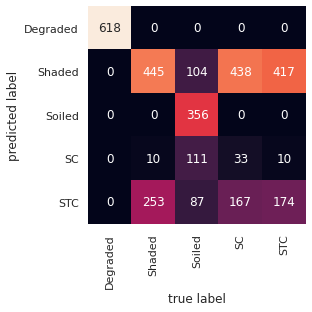

In [45]:
CM_svm = confusion_matrix(y_test_mc, svm_y_hat_final_test_mc)
ax = sns.heatmap(CM_svm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

# Neural Networks (Multi-layer Preceptrons)

Multi-layer Preceptrons are shallow neural networks (as opposed to deep learning networks).  This means that they usually only have a couple of hidden layers.  

These networks generally have the following structure:


![picture](https://www.tutorialspoint.com/tensorflow/images/multi_layer_perceptron.jpg)

### Tune Hyperparameters

We're definitely going to have to do some hyperparameter tuning on this - neural nets have more hyperparameters than other methods.

Here, our hyperparameters consist of:
* The number of hidden layers
* The number of hidden nodes in each hidden layer
* The activation function which can be ‘identity’, ‘logistic’, ‘tanh’, or ‘relu’ ('relu' is fairly standard).  See the documentation for more details.
* The type of solver which can be ‘lbfgs’, ‘sgd’, or ‘adam’.  'sgd' is standard gradiant descent, while 'adam' is a specialized version of gradient descent ('adam' is fairly standard)
* The max_iter specifies the maximum number of iterations.

The following code automatically tests a variety of hidden layers and hidden nodes though it uses the standard 'relu' activation function and 'adam' solver.  Feel free to play with these as well.

In [47]:
from sklearn.neural_network import MLPClassifier

#Try different hyperparameter values
hidden_layers = [25, 50, 100, 150, 200, 250, 300]

#Let's try for just one hidden layer
for hl in hidden_layers:
  NN_model = MLPClassifier(hidden_layer_sizes=(hl, ), activation='relu', solver='adam', max_iter=300)
  nn_model = NN_model.fit(x_train_mc, y_train_mc)
  nn_y_hat = nn_model.predict(x_val_mc)

  nn_accuracy = accuracy_score(y_val_mc, nn_y_hat)
  print('One hidden layer, ', hl, ' nodes. Validation accuracy = ', round(nn_accuracy * 100, 2), '%')

#Now we'll try two hidden layers
for hl in hidden_layers:
  NN_model = MLPClassifier(hidden_layer_sizes=(hl, hl), activation='relu', solver='adam', max_iter=300)
  nn_model = NN_model.fit(x_train_mc, y_train_mc)
  nn_y_hat = nn_model.predict(x_val_mc)

  nn_accuracy = accuracy_score(y_val_mc, nn_y_hat)
  print('Two hidden layers, ', hl, ' nodes. Validation accuracy = ', round(nn_accuracy * 100, 2), '%')

One hidden layer,  25  nodes. Validation accuracy =  71.14 %
One hidden layer,  50  nodes. Validation accuracy =  73.63 %
One hidden layer,  100  nodes. Validation accuracy =  51.47 %
One hidden layer,  150  nodes. Validation accuracy =  56.1 %
One hidden layer,  200  nodes. Validation accuracy =  58.18 %
One hidden layer,  250  nodes. Validation accuracy =  72.98 %
One hidden layer,  300  nodes. Validation accuracy =  50.2 %
Two hidden layers,  25  nodes. Validation accuracy =  50.17 %
Two hidden layers,  50  nodes. Validation accuracy =  70.34 %
Two hidden layers,  100  nodes. Validation accuracy =  60.84 %
Two hidden layers,  150  nodes. Validation accuracy =  75.21 %
Two hidden layers,  200  nodes. Validation accuracy =  75.4 %
Two hidden layers,  250  nodes. Validation accuracy =  83.06 %
Two hidden layers,  300  nodes. Validation accuracy =  82.87 %


### Perform final tests
The accuracy values you get above can change from run to run due to the random ordering of the data and so forth.  However, on my run, I found that two layers of about 250 hidden nodes each seemed to work the best.  So that's what I'm going to use for my final testing.

You'll notice that your final test accuracy is probably a little lower than your validation accuracy.  This is normal as we have selected hyperparameters that maximized THAT data.  This is the purpose of using both a validation and test set.  The results on the test set are unbiased and can be predictive for future data.

My experience with this is that the test accuracy can range significantly.  This suggests that the neural network model is unstable which is a common problem with this type of model.

In [50]:
NN_model = MLPClassifier(hidden_layer_sizes=(250, 250), activation='relu', solver='adam', max_iter=300)
nn_model = NN_model.fit(x_final_train_mc, y_final_train_mc)
nn_y_hat_test_final = nn_model.predict(x_test_mc)

nn_accuracy = accuracy_score(y_test_mc, nn_y_hat_test_final)
print('Test accuracy = ', round(nn_accuracy * 100, 2), '%')

Test accuracy =  68.72 %


### Confusion Matrix

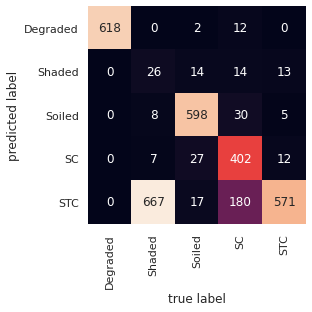

In [51]:
CM_nn = confusion_matrix(y_test_mc, nn_y_hat_test_final)
ax = sns.heatmap(CM_nn.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

#Unsupervised Clustering (K-Means)
How does unsupervised clustering compare with supervised classification?

We expect it to perform substantially worse than supervised clustering for two reasons:
1. We are throwing away a lot of information!  By not using the labels we are significantly reducing the amount of information that our algorithm can use.
2. When we visualized the data in two and three dimensions above, we noticed that the classes are not well separated.  They may be well separated in the full 10 dimensions, but this is unknown.  


### Cluster on Reduced Dimensionality Data
We're going to start with our dimensionality reduced data so we can visualize the clusters.  Because some of the clusters overlap in our 3d data (as opposed to the original 10 dimensions), we do not expect this to be very effective.

Notice that because we know that there are 5 types of data in our dataset, we do not need to try different numbers of clusters.

In [52]:
from sklearn.cluster import k_means

# Recall that the dimensionality reduced data is called X_red3, and the labels are y
X_clustered_3d = X_red3
y_clustered_3d = y

# Perform k-means clustering
centroids, y_clusters_3d_hat, cost = k_means(X_red3, n_clusters=5)

### Visualize Reduced Dimensionality Clusters

Here, we can plot the reduced and clusterd data in three dimensions.

In [64]:
fig2 = go.Figure(data=[go.Scatter3d(x=X_red3[:,0], y=X_red3[:,1], z=X_red3[:,2], 
                                   mode='markers', 
                                   marker=dict(
                                       size=5,
                                       color=y_clusters_3d_hat,                
                                       opacity=0.8))])

fig2.show()

Compare this to the actual classes that we originally visualized above.

In [65]:
fig1.show()

### Evaluate Reduced Dimensionality Clustering

There are many possible clusterings that you'll see, but none of them do a good job.

We can ONLY evaluate our clustering because we know the true data labels.

We were able to cluster digits with 26.36% accuracy.


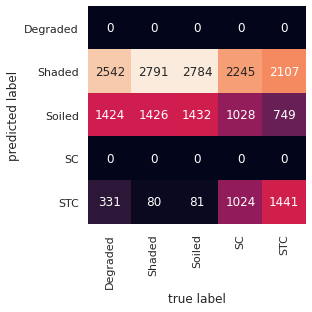

In [66]:
from scipy.stats import mode

# This will only work if the clusters overlap the actual classes to a reasonable 
# amount.  If they are way off, this will not be effective.
cluster_labels_3d = np.zeros_like(y_clusters_3d_hat)
for i in range(5):
    mask = (y_clusters_3d_hat == i)
    cluster_labels_3d[mask] = mode(y_clustered_3d[mask])[0]

# Determine the accuracy of our clustering
accuracy = accuracy_score(y_clustered_3d, cluster_labels_3d)
print("We were able to cluster digits with " + str(round(accuracy * 100, 2)) + "% accuracy.")

# Plot the confusion matrix
CM_clusters = confusion_matrix(y_clustered_3d, cluster_labels_3d)
ax = sns.heatmap(CM_clusters.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

If the above confusion matrix doesn't look right (one or more rows being all zeros), that's because the clustering is SO BAD that the technique we're doing to assign labels doesn't work.  In this case, the accuracy is more reliable than the confusion matrix.

### Cluster on Full Dimensionality

Since that didn't work, let's see what happens if we cluster the data in the original 10 dimensions.  Notice that we can't visualize it in 10 dimensions, so we're stuck with the accuracy and confusion matrix to see how well the clustering works.

In [67]:
X_clustered_10d = X
y_clustered_10d = y

# Perform k-means clustering
centroids, y_clusters_10d_hat, cost = k_means(X_clustered_10d, n_clusters=5, n_init=50)

# This will only work if the clusters overlap the actual classes to a reasonable 
# amount.  If they are way off, this will not be effective.
cluster_labels_10d = np.zeros_like(y_clusters_10d_hat)
for i in range(5):
    mask = (y_clusters_10d_hat == i)
    cluster_labels_10d[mask] = mode(y_clustered_10d[mask])[0]

### Evaluate Full Dimensionality Clustering

We can ONLY evaluate our clustering because we know the true data labels.

We were able to cluster digits with 26.35% accuracy.


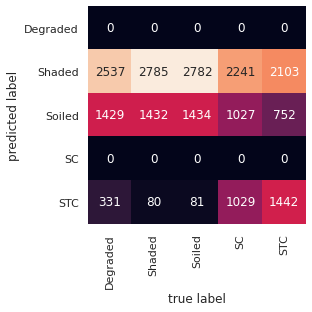

In [68]:
# Determine the accuracy of our clustering
accuracy = accuracy_score(y_clustered_10d, cluster_labels_10d)
print("We were able to cluster digits with " + str(round(accuracy * 100, 2)) + "% accuracy.")

# Plot the confusion matrix
CM_clusters = confusion_matrix(y_clustered_10d, cluster_labels_10d)
ax = sns.heatmap(CM_clusters.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'],
            yticklabels=['Degraded','Shaded','Soiled', 'SC', 'STC'])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

That didn't work at all!  It looks like clustering, even in 10 dimensions, is not an effective technique for this dataset.  

So in this situation, supervised classification performs MUCH better than an unsupervised clustering.

#Conclusions

The values and accuracies are going to change slightly each time you run this file due to the random assignment into the train, validation, and test sets.  But you should note the following general conclusions:
* Logistic Regression and Neural Networks performed significantly better than Support Vector Machines on this data. This will NOT be true on all datasets which is why trying different algorithms can be very useful.
* Unsupervised clustering is MUCH less effective than supervised classification.  Take-away - if you have labels, use them!